H, He, C, O, Ne, Mg, Si, S, Ar, Ca, Fe

https://www.sciencedirect.com/science/article/pii/S221455241400011X

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log10


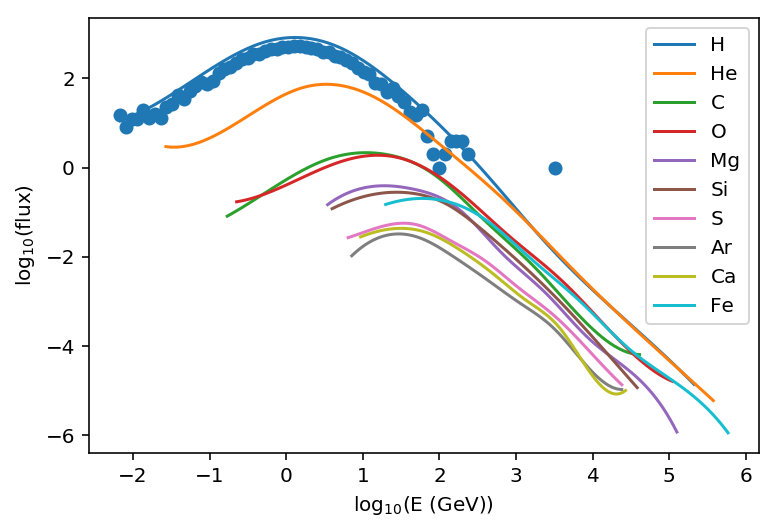

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate, scipy.integrate
import glob


def getElementData(element):
    """
    Obtained from http://lpsc.in2p3.fr/crdb
    """
    energies = []
    fluxes = []
    for filename in glob.glob(f'GCRdata/{element}/*.dat'):
        with open(filename, 'r') as f:
            lines = f.read()
        lines = lines.split('\n')
        for line in lines:
            # Ignore comments and newlines
            if not '#' in line and len(line) > 1:
                data = [float(d) for d in line.split()]
                # Ignore 0 energies which cause log problems
                if data[0] > 0:
                    energies.append(data[0])
                    fluxes.append(data[3])
    return np.array(energies), np.array(fluxes)


def getElementFunction(element):
    """
    Return min energy, max energy, and function (all log10).
    """
    energies, fluxes = getElementData(element)
    fluxes = energies*fluxes
    logEnergies = np.log10(energies)
    logFluxes = np.log10(fluxes)
    bins, samples = binnedAverage(logEnergies, logFluxes, bins=10)
    f = scipy.interpolate.interp1d(bins, samples, kind='cubic')
    return min(bins), max(bins), f


def binnedAverage(x, y, bins=20):
    xbins, step = np.linspace(np.min(x), np.max(x), num=bins, retstep=True)
    xbins = (xbins + step/2)[:-1]
    emptyBins = []
    ymeans = []
    for xbi, xb in enumerate(xbins):
        ytotal = 0
        ycount = 0
        for y_i, y_ in enumerate(y):
            if xb - step/2 < x[y_i] < xb + step/2:
                ytotal += y_
                ycount += 1
        if ycount >= 1:
            ymeans.append(ytotal/ycount)
        else:
            emptyBins.append(xbi)
    xbins = np.delete(xbins, emptyBins)
    return xbins, np.array(ymeans)


fig, ax = plt.subplots()
for element in ['H', 'He', 'C', 'O', 'Mg', 'Si', 'S', 'Ar', 'Ca', 'Fe']:
    fmin, fmax, f = getElementFunction(element)
    fx = np.linspace(fmin, fmax, 100)
    fy = [f(fxi) for fxi in fx]
    if element == 'H':
        energies, fluxes = getElementData(element)
        fluxes = energies*fluxes
        logEnergies = np.log10(energies)
        logFluxes = np.log10(fluxes)
        bins, samples = fx, fy
        samples = np.array([10**s for s in samples])
        samples /= np.sum(samples)
        counts = np.zeros(len(samples))
        for _ in range(10000):
            counts[np.digitize(np.random.choice(bins, p=samples), bins, right=True)] += 1
        plt.scatter(bins, np.log10(counts))
    ax.plot(fx, fy, label=element)
ax.set_ylabel('log$\mathregular{_{10}}$(flux)')
ax.set_xlabel('log$\mathregular{_{10}}$(E (GeV))')
ax.legend();

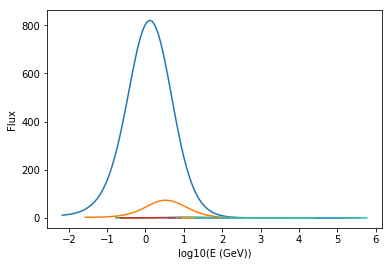

In [3]:
fig, ax = plt.subplots()
for element in ['H', 'He', 'C', 'O', 'Mg', 'Si', 'S', 'Ar', 'Ca', 'Fe']:
    fmin, fmax, f = getElementFunction(element)
    fx = np.linspace(fmin, fmax, 100)
    fy = [f(fxi) for fxi in fx]
    ax.plot(fx, [10**fyi for fyi in fy])
ax.set_ylabel('Flux')
ax.set_xlabel('log10(E (GeV))');

In [86]:
[1,2]/np.sum([1,3])

array([0.25, 0.5 ])

In [7]:
def KEtoSpeed(KE, mass):
    """
    Relativistic formula to convert kinetic energy and mass (eV) to speed (m/s).
    """
    return 299792458*(1-(KE/mass+1)**-2)**.5


def qmv(particleCount):
    elements = ['H', 'He', 'C', 'O', 'Mg', 'Si', 'S', 'Ar', 'Ca', 'Fe']
    u = 931.4941e6 # to eV/c^2
    mDict = {'H': 1.008*u, 'He': 4.0026*u, 'C': 12.011*u, 'O': 15.999*u, 'Mg': 24.305*u, 
             'Si': 28.085*u, 'S': 32.06*u, 'Ar': 39.948*u, 'Ca': 40.078*u, 'Fe': 55.845*u}
    e = 1.60217662e-19
    qDict = {'H': 1*e, 'He': 2*e, 'C': 6*e, 'O': 8*e, 'Mg': 12*e, 
             'Si': 14*e, 'S': 16*e, 'Ar': 18*e, 'Ca': 20*e, 'Fe': 26*e}
    elemBins = []
    elemPDFs = []
    elemIntegrals = []
    for element in elements:
        fmin, fmax, f = getElementFunction(element)
        fx = np.linspace(fmin, fmax, 100)
        fy = [10**f(fxi) for fxi in fx]
        fy /= np.sum(fy)
        
        elemBins.append(fx)
        elemPDFs.append(fy)
        elemIntegrals.append(scipy.integrate.quad(lambda x: x*10**f(x), fmin, fmax)[0])

    elemIntegrals /= np.sum(elemIntegrals)
    elemChoices = [np.random.choice(elements, p=elemIntegrals) for _ in range(particleCount)]
    qm = [qDict[e]/mDict[e] for e in elemChoices]
    elemIndices = [elements.index(e) for e in elemChoices]
    v = [KEtoSpeed(1e9*10**np.random.choice(elemBins[e], p=elemPDFs[e]), mDict[elements[e]]) 
         for e in elemIndices]
    return qm, v


qmv(10)

([1.7063564144310552e-28,
  1.7063564144310552e-28,
  1.7063564144310552e-28,
  8.594449936273938e-29,
  1.7063564144310552e-28,
  1.7063564144310552e-28,
  1.7063564144310552e-28,
  1.7063564144310552e-28,
  8.594449936273938e-29,
  8.594449936273938e-29],
 [291222236.1588053,
  293280454.6864844,
  249062017.8385709,
  165730475.080394,
  164944571.37297854,
  298728797.55309296,
  257290932.49775466,
  281461197.1103755,
  165730475.080394,
  246442888.93076617])